# DuckDB Analysis Template for `exp_engine`

This notebook connects directly to your **HIVE-partitioned Parquet datasets** written by the experiment engine, builds **instant DuckDB views**, and runs **fast SQL-first analysis** with light Python plotting.

**Highlights**
- Keep the heavy data in Parquet; pull back only small aggregates
- Derived metrics view: `seeds_enriched` (regret ratio, pass flags, ρ-utilization)
- Ready-made queries: overall, by-grid, by-controls, ECDF, violin, interactions
- Privacy diagnostics: ρ-utilization + per-op γ-split checks
- (Optional) Persist small report tables in DuckDB for dashboards

> **Note:** Make sure your results path below points at the folder where `exp_engine` wrote `seeds/` and `events/`.


In [24]:
# --- Prerequisites (uncomment if needed) ---
# %pip install duckdb pandas matplotlib
# %pip install exp_engine  # if distributed as a package; else ensure it's on PYTHONPATH

import duckdb, pandas as pd, numpy as np, matplotlib.pyplot as plt
from exp_engine.engine.duck import create_connection_and_views

plt.rcParams.update({'figure.figsize': (5,3), 'axes.grid': True})

BASE_OUT = "/workspaces/basic-python/unlearning-research-meta/experiments/deletion_capacity/results_parquet"  # <--- change if your Parquet base_out lives elsewhere

conn = create_connection_and_views(BASE_OUT)
conn.execute("PRAGMA threads=8;")
conn.execute("PRAGMA enable_progress_bar=false;")

print("Connected. Views available:")
print(conn.execute("SHOW TABLES;").df())

Connected. Views available:
            name
0          seeds
1  seeds_summary


In [ ]:
command = """
CREATE OR REPLACE VIEW seeds_enriched AS
SELECT
  s.*,

  -- This column is IMPROVEMENT (negative is better)
  avg_regret_empirical                              AS avg_improvement,

  -- Normalize so "bigger is better" (positive score)
  CASE WHEN gamma_bar > 0
       THEN (-avg_regret_empirical) / gamma_bar
  END                                               AS norm_improvement,

  -- Headroom to threshold (≥0 means pass, <0 means fail)
  CASE WHEN gamma_bar IS NOT NULL
       THEN gamma_bar + avg_regret_empirical
  END                                               AS improvement_margin,

  -- Pass if required improvement magnitude is within γ̄
  CASE WHEN avg_regret_empirical IS NOT NULL AND gamma_bar IS NOT NULL
       THEN (-avg_regret_empirical <= gamma_bar)
  END                                               AS pass_overall,

  -- Privacy utilization
  CASE WHEN rho_total > 0 AND rho_spent_final IS NOT NULL
       THEN rho_spent_final / rho_total
  END                                               AS rho_util
FROM seeds s;

"""
conn.execute(command)

Empty DataFrame
Columns: [Count]
Index: []


In [27]:
command = """
-- Best grids (larger = better)
SELECT
  grid_id,
  COUNT(*)                                         AS n,
  AVG(CASE WHEN pass_overall THEN 1 ELSE 0 END)    AS pass_rate,
  quantile_cont(norm_improvement, 0.5)             AS median_norm_imp,
  quantile_cont(norm_improvement, 0.9)             AS p90_norm_imp
FROM seeds_enriched
GROUP BY 1
ORDER BY median_norm_imp DESC, p90_norm_imp DESC, n DESC
LIMIT 20;
"""

print(conn.execute(command).df().head())


                                             grid_id   n  pass_rate  \
0  gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...  10        0.0   
1  gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...  10        0.0   
2  gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...  10        0.0   
3  gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...  10        0.0   
4  gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...  10        0.0   

   median_norm_imp  p90_norm_imp  
0         3.718065      4.135954  
1         3.718065      4.135954  
2         3.718065      4.135954  
3         3.718065      4.135954  
4         3.718065      4.135954  


In [28]:
command = """
-- PT × split (where we saw strong interactions before)
SELECT
  target_PT, gamma_split,
  COUNT(*)                                   AS n,
  quantile_cont(norm_improvement, 0.5)       AS med_norm_imp,
  quantile_cont(norm_improvement, 0.9)       AS p90_norm_imp
FROM seeds_enriched
GROUP BY 1,2
ORDER BY med_norm_imp DESC, p90_norm_imp DESC, n DESC;

-- Delete ratio effect (monotonicity check)
SELECT
  delete_ratio,
  COUNT(*)                             AS n,
  quantile_cont(norm_improvement,0.5)  AS med_norm_imp,
  quantile_cont(norm_improvement,0.9)  AS p90_norm_imp
FROM seeds_enriched
GROUP BY 1
ORDER BY delete_ratio;

"""

print(conn.execute(command).df().head())


   delete_ratio    n  med_norm_imp  p90_norm_imp
0             3  664      3.632566      4.434942
1             5  560      3.672142      4.418104


In [29]:
command = """
-- Per-slice γ̄ needed for 95% pass
SELECT
  target_PT, delete_ratio, gamma_split,
  COUNT(*)                                      AS n,
  quantile_cont(-avg_improvement, 0.95)         AS gamma_needed_p95,
  quantile_cont(-avg_improvement, 0.50)         AS gamma_needed_p50
FROM seeds_enriched
GROUP BY 1,2,3
ORDER BY target_PT, delete_ratio, gamma_split;
"""

print(conn.execute(command).df().head())


   target_PT  delete_ratio  gamma_split    n  gamma_needed_p95  \
0        NaN             3          0.3  664          4.573247   
1        NaN             5          0.3  560          4.606139   

   gamma_needed_p50  
0          3.632566  
1          3.672142  


## 1) Sanity checks

In [4]:
print(conn.execute("SELECT COUNT(*) AS n_seeds FROM seeds_enriched;").df())
conn.execute("SELECT * FROM seeds_enriched LIMIT 5;").df()

   n_seeds
0     1224


,gamma_bar,gamma_split,accountant,delete_ratio,rotate_angle,drift_rate,G_hat,D_hat,c_hat,C_hat_1,...,gamma_delete_threshold,gamma_pass_overall,gamma_pass_insert,gamma_pass_delete,gamma_error,grid_id,avg_regret,regret_ratio,pass_overall,rho_util_1
0,1.0,0.3,eps_delta,3,0.01,NaN,19.030060,0.498326,1.0,1.0,...,0.7,True,True,True,0.0,gamma_1.0-split_0.3_q0.90_k3_zcdp_rho1.0_cmpst...,-1.827412,-1.827412,True,0.0
1,1.0,0.3,eps_delta,3,0.01,NaN,19.030060,0.498326,1.0,1.0,...,0.7,True,True,True,0.0,gamma_1.0-split_0.3_q0.90_k3_zcdp_rho1.0_cmpst...,-1.827412,-1.827412,True,0.0
2,1.0,0.3,eps_delta,3,0.01,NaN,28.251018,0.533339,1.0,1.0,...,0.7,True,True,True,0.0,gamma_1.0-split_0.3_q0.90_k3_zcdp_rho1.0_cmpst...,-3.652912,-3.652912,True,0.0
3,1.0,0.3,eps_delta,3,0.01,NaN,19.030060,0.498326,1.0,1.0,...,0.7,True,True,True,0.0,gamma_1.0-split_0.3_q0.90_k3_zcdp_rho1.0_cmpst...,-1.827412,-1.827412,True,0.0
4,1.0,0.3,eps_delta,3,0.01,NaN,38.598160,0.532893,1.0,1.0,...,0.7,True,True,True,0.0,gamma_1.0-split_0.3_q0.90_k3_zcdp_rho1.0_cmpst...,-4.049980,-4.049980,True,0.0


## 2) Core summaries

In [5]:
# Overall summary
overall = conn.execute(
    """
    SELECT
      COUNT(*)                                         AS n_seeds,
      SUM(CASE WHEN regret_ratio IS NOT NULL THEN 1 ELSE 0 END) AS n_with_ratio,
      AVG(CASE WHEN pass_overall THEN 1 ELSE 0 END)    AS pass_rate_overall,
      quantile_cont(regret_ratio, 0.5)                 AS median_r,
      quantile_cont(regret_ratio, 0.9)                 AS p90_r
    FROM seeds_enriched;
    """
).df()
overall

,n_seeds,n_with_ratio,pass_rate_overall,median_r,p90_r
0,1224,1224.0,1.0,-3.642356,-1.831692


In [6]:
# Loosest grids (lowest median r)
by_grid = conn.execute(
    """
    SELECT
      grid_id,
      COUNT(*)                                          AS n,
      AVG(CASE WHEN pass_overall THEN 1 ELSE 0 END)     AS pass_rate,
      quantile_cont(regret_ratio, 0.5)                  AS median_r,
      quantile_cont(regret_ratio, 0.9)                  AS p90_r
    FROM seeds_enriched
    GROUP BY 1
    ORDER BY median_r ASC, p90_r ASC, n DESC
    LIMIT 20;
    """
).df()
by_grid.head(10)

,grid_id,n,pass_rate,median_r,p90_r
0,gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...,10,1.0,-3.718065,-1.868039
1,gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...,10,1.0,-3.718065,-1.868039
2,gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...,10,1.0,-3.718065,-1.868039
3,gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...,10,1.0,-3.718065,-1.868039
4,gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...,10,1.0,-3.718065,-1.868039
5,gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...,10,1.0,-3.718065,-1.868039
6,gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...,10,1.0,-3.718065,-1.868039
7,gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...,10,1.0,-3.718065,-1.868039
8,gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...,10,1.0,-3.718065,-1.868039
9,gamma_1.0-split_0.3_q0.90_k5_zcdp_rho1.0_cmpst...,10,1.0,-3.718065,-1.868039


In [7]:
# By-controls summary (customize columns to the knobs you varied)
by_ctrl = conn.execute(
    """
    SELECT
      gamma_bar, gamma_split, rho_total, delete_ratio, target_PT,
      COUNT(*)                                      AS n,
      AVG(CASE WHEN pass_overall THEN 1 ELSE 0 END) AS pass_rate,
      quantile_cont(regret_ratio, 0.5)              AS median_r,
      quantile_cont(regret_ratio, 0.9)              AS p90_r
    FROM seeds_enriched
    GROUP BY 1,2,3,4,5
    ORDER BY median_r ASC, p90_r ASC, n DESC
    LIMIT 200;
    """
).df()
by_ctrl.head(20)

,gamma_bar,gamma_split,rho_total,delete_ratio,target_PT,n,pass_rate,median_r,p90_r
0,1.0,0.3,1.0,5,NaN,560,1.0,-3.672142,-1.868039
1,1.0,0.3,1.0,3,NaN,664,1.0,-3.632566,-1.827412


## 3) ECDF and violin plots
Pull only small, aggregated data for plotting—let DuckDB do the heavy lifting.

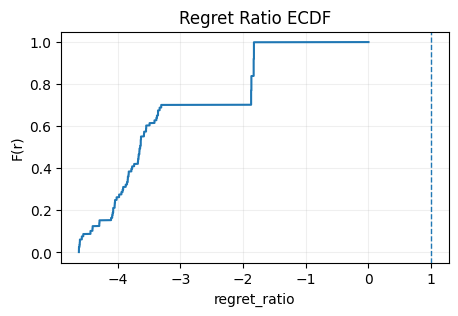

In [8]:
# ECDF of regret_ratio
ecdf = conn.execute(
    """
    WITH vals AS (
      SELECT regret_ratio AS r FROM seeds_enriched WHERE regret_ratio IS NOT NULL
    ),
    ord AS (
      SELECT r,
             ROW_NUMBER() OVER (ORDER BY r) AS rn,
             COUNT(*)  OVER ()              AS n
      FROM vals
    )
    SELECT r, CAST(rn AS DOUBLE)/n AS ecdf
    FROM ord
    ORDER BY r;
    """
).df()

plt.figure()
plt.plot(ecdf["r"], ecdf["ecdf"])
plt.axvline(1.0, linestyle='--', linewidth=1)
plt.title("Regret Ratio ECDF")
plt.xlabel("regret_ratio")
plt.ylabel("F(r)")
plt.grid(alpha=0.2)
plt.show()

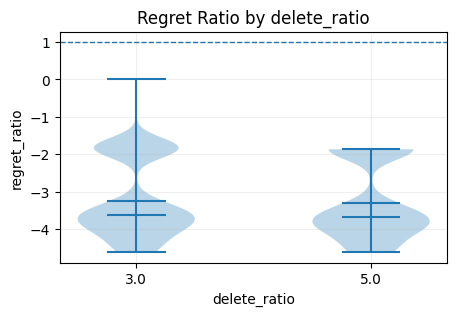

In [9]:
# Violin by a factor (example: delete_ratio)
samples = conn.execute(
    """
    SELECT CAST(delete_ratio AS DOUBLE) AS factor, regret_ratio
    FROM seeds_enriched
    WHERE regret_ratio IS NOT NULL AND delete_ratio IS NOT NULL;
    """
).df()

cats = sorted(samples["factor"].dropna().unique())
data = [samples.loc[samples["factor"]==c, "regret_ratio"].values for c in cats]

plt.figure()
plt.violinplot(data, showmeans=True, showmedians=True)
plt.xticks(range(1, len(cats)+1), [str(c) for c in cats])
plt.axhline(1.0, linestyle='--', linewidth=1)
plt.title("Regret Ratio by delete_ratio")
plt.xlabel("delete_ratio")
plt.ylabel("regret_ratio")
plt.grid(alpha=0.2)
plt.show()

## 4) Effects & interactions

In [10]:
# Global baselines for deltas
global_stats = conn.execute(
    """
    SELECT
      quantile_cont(regret_ratio, 0.5) AS median_r,
      quantile_cont(regret_ratio, 0.9) AS p90_r
    FROM seeds_enriched
    WHERE regret_ratio IS NOT NULL;
    """
).df().iloc[0]
g_med, g_p90 = float(global_stats.median_r), float(global_stats.p90_r)
g_med, g_p90

(-3.6423559535791523, -1.8316924366809006)

In [11]:
# Marginal effects by control
marginals = conn.execute(
    """
    WITH marg AS (
      SELECT 'gamma_bar'     AS control, CAST(gamma_bar     AS DOUBLE) AS level,
             COUNT(*) AS n, quantile_cont(regret_ratio,0.5) AS med, quantile_cont(regret_ratio,0.9) AS p90
        FROM seeds_enriched WHERE regret_ratio IS NOT NULL GROUP BY 2
      UNION ALL
      SELECT 'gamma_split',  CAST(gamma_split  AS DOUBLE), COUNT(*), quantile_cont(regret_ratio,0.5), quantile_cont(regret_ratio,0.9)
        FROM seeds_enriched WHERE regret_ratio IS NOT NULL GROUP BY 2
      UNION ALL
      SELECT 'target_PT',    CAST(target_PT    AS DOUBLE), COUNT(*), quantile_cont(regret_ratio,0.5), quantile_cont(regret_ratio,0.9)
        FROM seeds_enriched WHERE regret_ratio IS NOT NULL GROUP BY 2
      UNION ALL
      SELECT 'delete_ratio', CAST(delete_ratio AS DOUBLE), COUNT(*), quantile_cont(regret_ratio,0.5), quantile_cont(regret_ratio,0.9)
        FROM seeds_enriched WHERE regret_ratio IS NOT NULL GROUP BY 2
      UNION ALL
      SELECT 'rho_total',    CAST(rho_total    AS DOUBLE), COUNT(*), quantile_cont(regret_ratio,0.5), quantile_cont(regret_ratio,0.9)
        FROM seeds_enriched WHERE regret_ratio IS NOT NULL GROUP BY 2
    )
    SELECT control, level, n, med, p90
    FROM marg
    ORDER BY control, med ASC, p90 ASC;
    """
).df()

marginals["abs_med_delta"] = (marginals["med"] - g_med).abs()
marginals.sort_values(["abs_med_delta","control"], ascending=[False, True]).head(12)

,control,level,n,med,p90,abs_med_delta
0,delete_ratio,5.0,560,-3.672142,-1.868039,0.029786
1,delete_ratio,3.0,664,-3.632566,-1.827412,0.009789
2,gamma_bar,1.0,1224,-3.642356,-1.831692,0.000000
3,gamma_split,0.3,1224,-3.642356,-1.831692,0.000000
4,rho_total,1.0,1224,-3.642356,-1.831692,0.000000
5,target_PT,NaN,1224,-3.642356,-1.831692,0.000000


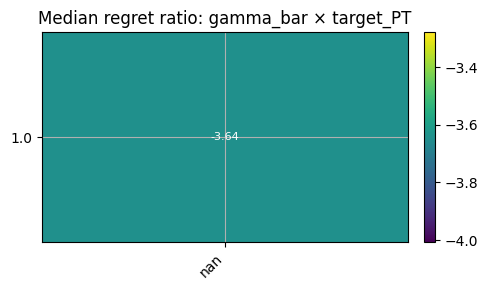

In [12]:
# Interaction heatmap: gamma_bar × target_PT
heat = conn.execute(
    """
    SELECT
      CAST(gamma_bar AS DOUBLE) AS gamma_bar,
      CAST(target_PT AS DOUBLE) AS target_PT,
      quantile_cont(regret_ratio, 0.5) AS median_r
    FROM seeds_enriched
    WHERE regret_ratio IS NOT NULL
    GROUP BY 1,2
    ORDER BY 1,2;
    """
).df()

if not heat.empty:
    pivot = heat.pivot(index="gamma_bar", columns="target_PT", values="median_r")
    plt.figure(figsize=(5,3))
    im = plt.imshow(pivot.values, aspect='auto')
    plt.xticks(range(len(pivot.columns)), [str(c) for c in pivot.columns], rotation=45, ha='right')
    plt.yticks(range(len(pivot.index)),  [str(i) for i in pivot.index])
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Median regret ratio: gamma_bar × target_PT")
    for yi in range(pivot.shape[0]):
        for xi in range(pivot.shape[1]):
            val = pivot.values[yi, xi]
            if np.isfinite(val):
                plt.text(xi, yi, f"{val:.2f}", ha='center', va='center', fontsize=8, color='white')
    plt.tight_layout(); plt.show()
else:
    print("No data for interaction heatmap.")

## 5) Privacy diagnostics

In [13]:
# ρ utilization summary
rho_stats = conn.execute(
    """
    SELECT
      COUNT(*)                                        AS n_with_rho,
      quantile_cont(rho_util, 0.5)                    AS rho_util_median,
      quantile_cont(rho_util, 0.9)                    AS rho_util_p90,
      MAX(rho_util)                                   AS rho_util_max
    FROM seeds_enriched
    WHERE rho_util IS NOT NULL;
    """
).df()
rho_stats

,n_with_rho,rho_util_median,rho_util_p90,rho_util_max
0,1224,0.0,0.0,0.0


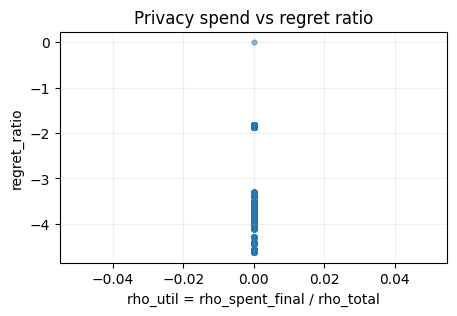

In [14]:
# Scatter: rho_util vs regret_ratio
rho_scatter = conn.execute(
    """
    SELECT rho_util, regret_ratio
    FROM seeds_enriched
    WHERE rho_util IS NOT NULL AND regret_ratio IS NOT NULL;
    """
).df()

if not rho_scatter.empty:
    plt.figure()
    plt.scatter(rho_scatter["rho_util"], rho_scatter["regret_ratio"], s=12, alpha=0.5)
    plt.xlabel("rho_util = rho_spent_final / rho_total")
    plt.ylabel("regret_ratio")
    plt.title("Privacy spend vs regret ratio")
    plt.grid(alpha=0.2)
    plt.show()
else:
    print("No rho/util or regret_ratio data to plot.")

In [15]:
# Per-op mean regret and γ-split pass checks (events-level)
perop = conn.execute(
    """
    SELECT
      grid_id,
      AVG(CASE WHEN op='insert' THEN regret END) AS insert_mean,
      AVG(CASE WHEN op='delete' THEN regret END) AS delete_mean,
      ANY_VALUE(gamma_bar)   AS gamma_bar,
      ANY_VALUE(gamma_split) AS gamma_split
    FROM events_light
    GROUP BY 1;
    """
).df()

if not perop.empty:
    perop["insert_pass"] = perop["insert_mean"] <= perop["gamma_bar"] * perop["gamma_split"]
    perop["delete_pass"] = perop["delete_mean"] <= perop["gamma_bar"] * (1 - perop["gamma_split"])
    perop.head(10)
else:
    print("No events data available for per-op checks.")

CatalogException: Catalog Error: Table with name events_light does not exist!
Did you mean "pg_settings"?

LINE 8:     FROM events_light
                 ^

## 6) Persist small report tables (optional)
Use these as sources for dashboards or to avoid recomputing summaries.

In [ ]:
conn.execute("CREATE SCHEMA IF NOT EXISTS reports;")

conn.execute(
    """
    CREATE OR REPLACE TABLE reports.overall AS
    SELECT * FROM (
      SELECT
        COUNT(*)                                         AS n_seeds,
        AVG(CASE WHEN pass_overall THEN 1 ELSE 0 END)    AS pass_rate_overall,
        quantile_cont(regret_ratio, 0.5)                 AS median_r,
        quantile_cont(regret_ratio, 0.9)                 AS p90_r
      FROM seeds_enriched
    );
    """
)

conn.execute(
    """
    CREATE OR REPLACE TABLE reports.by_controls AS
    SELECT
      gamma_bar, gamma_split, rho_total, delete_ratio, target_PT,
      COUNT(*)                                      AS n,
      AVG(CASE WHEN pass_overall THEN 1 ELSE 0 END) AS pass_rate,
      quantile_cont(regret_ratio, 0.5)              AS median_r,
      quantile_cont(regret_ratio, 0.9)              AS p90_r
    FROM seeds_enriched
    GROUP BY 1,2,3,4,5;
    """
)

print(conn.execute("SELECT * FROM reports.overall;").df())
print(conn.execute("SELECT * FROM reports.by_controls LIMIT 10;").df())

## 7) Export light CSVs (optional)
Write out small CSVs for sharing or quick diffs.

In [ ]:
EXPORT_DIR = "exports"  # change if desired
os.makedirs(EXPORT_DIR, exist_ok=True)

overall.to_csv(os.path.join(EXPORT_DIR, "overall.csv"), index=False)
by_grid.to_csv(os.path.join(EXPORT_DIR, "by_grid_top20.csv"), index=False)
by_ctrl.to_csv(os.path.join(EXPORT_DIR, "by_controls.csv"), index=False)
print("Wrote:", os.listdir(EXPORT_DIR))

### Next steps
- Add your custom KPIs to `seeds_enriched` once and reuse across queries.
- If events are huge, sample with `WHERE seed IN (...)` or add time windows.
- Create more `reports.*` tables for dashboards or save plots to disk for CI artifacts.